# NNIA 18/19 Project 2:  Gradient Descent & Backpropagation

## Deadline: 4. January 2018, 23:59

## 1. Multinomial Logistic Regression and Cross Validation $~$ (12 points)

In this exercise, you will implement a [multinomial logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) model with tensorflow for Fashion-MNIST dataset. Cross Validation will be used to find the best **regularization parameter** $\lambda$ for the L2-regularization term. Fashion-MNIST dataset is similar to the sklearn Digit dataset you used in the Project 1. It contains 60,000 training images and 10,000 testing images. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

![Neural Network](https://s3-eu-central-1.amazonaws.com/zalando-wp-zalando-research-production/2017/08/fashion-mnist-sprite.png)

Multinomial logistic regression is a probabilistic, linear classifier. It is parametrized by a weight matrix $W$ and a bias vector $b$. Classification is done by projecting an input vector onto a set of hyperplanes, each of which corresponds to a class. The distance from the input to a hyperplane reflects the probability that the input is a member of the corresponding class.

Mathematically, the probability that an input vector $\bf{x} \in \mathbb{R}^p$ is a member of a class $i$ can be written as:
$$P(Y=i|\textbf{x}, W, b) = softmax(W\textbf{x} + b)_i = \frac{e^{W_i\textbf{x} + b_i}}{\sum_j{e^{W_j\textbf{x} + b_j}}}$$
where $W \in \mathbb{R}^{c \times p}$, $b \in \mathbb{R}^c$ and $W_i \in \mathbb{R}^p$.

The model’s prediction $y_{pred}$ is the class whose probability is maximal, specifically:
$$y_{pred} = argmax_iP(Y=i|\textbf{x}, W, b)$$

We use cross-entropy loss with L2 regularization.

### 1.1 Dataset and Normalization

Load **Fashion-MNIST** dataset and normalized it.

In [27]:
import os
import struct
import numpy as np
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist
(X_trainval, Y_trainval), (X_test, Y_test) = fashion_mnist.load_data()

In [28]:
X_trainval = np.reshape(X_trainval, (X_trainval.shape[0],  X_trainval.shape[1] *  X_trainval.shape[2]))
print('The X_trainval has the following shape:')
print('Rows: %d, columns: %d' % (X_trainval.shape[0], X_trainval.shape[1]))
print(X_trainval)


The X_trainval has the following shape:
Rows: 60000, columns: 784
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [29]:
X_test = np.reshape(X_test, (X_test.shape[0],  X_test.shape[1] *  X_test.shape[2]))
print('The X_test has the following shape:')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

The X_test has the following shape:
Rows: 10000, columns: 784


Normalize the data. Subtract the mean and divide by the standard deviation.

In [30]:
def data_normalization(X_trainval, X_test):
    # TODO: Implement
    trainval_mean = np.mean(X_trainval, axis=0)
    trainval_sd = np.std(X_trainval, axis=0)
    test_mean = np.mean(X_test, axis=0)
    test_sd = np.std(X_test, axis=0)
    
    X_trainval_normalized = np.array([[(x-trainval_mean[i])/trainval_sd[i] for i,x in enumerate(trainval_row)]
                                     for trainval_row in X_trainval])
    X_test_normalized = np.array([[(x-test_mean[i])/test_sd[i] for i,x in enumerate(test_row)] 
                                   for test_row in X_test])
    
    return X_trainval_normalized, X_test_normalized

In [31]:
# The normalization should be done on X_train and X_test. 
# The normalized data should have the exactly same shape as the original data matrix.
X_trainval, X_test = data_normalization(X_trainval, X_test)
#print(X_trainval)
#print(X_test)

---
**Points:** $0.0$ of $1.0$
**Comments:** None

---

### 1.2 Define the Computation Graph

In [32]:
# Here the global configuration of this program is 
# defined, which you shouldn't change.

class global_config(object):
    lr = 0.0001  # learning rate
    img_h = 28  # image height
    img_w = 28  # image width
    num_class = 10  # number of classes
    num_epoch = 20  # number of training epochs
    batch_size = 16  # batch size
    K = 3  # K-fold cross validation
    num_train = None  # the number of training data
    lambd = None  # the factor for the L2-regularization

config = global_config()
config.num_train = X_trainval.shape[0]

In [33]:
def train_val_split(X_trainval, Y_trainval, i, K):
    """
    sklearn library is not allowed to use here.
    
    K is the total number of folds and i is the current fold.
    
    Think about how to deal with the case when the number of 
    training data can't be divided by K evenly.
    """
    #TODO: Implement
    quotient, modulo = divmod(X_trainval.shape[0], K)
    diff_1 = -1
    diff_2 = 0
    
    if K-i < modulo:
        diff_1 += abs((K-i)-modulo) # Calculate difference
        diff_2 += abs((K-i)-modulo)
    else:
        diff_1 = 0
        
    X_val = X_trainval[quotient*(i-1)+diff_1:quotient*i+diff_2]
    X_train = np.concatenate((X_trainval[:quotient*(i-1)+diff_1], X_trainval[quotient*i+diff_2:]), axis=0)
    
    Y_val = Y_trainval[quotient*(i-1)+diff_1:quotient*i+diff_2]
    Y_train = np.concatenate([Y_trainval[:quotient*(i-1)+diff_1], Y_trainval[quotient*i+diff_2:]])
    
    return X_train, X_val, Y_train, Y_val

In [34]:
#test
X_train, X_val, Y_train, Y_val = train_val_split(X_trainval, Y_trainval, 5, 7)
print(X_val.shape)

(8572, 784)


---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

In [35]:
def shuffle_train_data(X_train, Y_train):
    """called after each epoch"""
    perm = np.random.permutation(len(Y_train))
    Xtr_shuf = X_train[perm]
    Ytr_shuf = Y_train[perm]
    return Xtr_shuf, Ytr_shuf

In [36]:
"""
training
"""
class logistic_regression(object):
    
    def __init__(self, X, Y_gt, config, name):
        """
        :param X: the training batch, which has the shape [batch_size, n_features].
        :param Y_gt: the corresponding ground truth label vector.
        :param config: the hyper-parameters you need for the implementation.
        :param name: the name of this logistic regression model which is used to
                     avoid the naming confict with the help of tf.variable_scope and reuse.
       
        Define the computation graph within the variable_scope here. 
        First define two variables W and b with tf.get_variable.
        Then do the forward pass.
        Then compute the cross entropy loss with tensorflow, don't forget the L2-regularization.
        The Adam optimizer is already given. You shouldn't change it.
        Finally compute the accuracy for one batch
        """
        self.config = config
        with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
            #TODO: Define two variables and the forward pass.
            weights = tf.get_variable("weights", [X.shape[1], config.num_class], initializer=tf.random_normal_initializer())
            biases = tf.get_variable("biases", [config.num_class], initializer=tf.constant_initializer(0.0))
            
            logits = tf.add(tf.matmul(X, weights), biases)
            
            #TODO: Compute the cross entropy loss with L2-regularization.
            self._loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_gt))
            regularizer = tf.nn.l2_loss(weights)
            self._loss = tf.reduce_mean(self._loss + config.lambd * regularizer)
            
            # Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent 
            # to update network weights iteratively.
            # It will be introduced in the lecture when talking about the optimization algorithms.
            self._train_step = tf.train.AdamOptimizer(config.lr).minimize(self._loss)
            
            #TODO: Compute the accuracy
            correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y_gt, 1), name='correct_pred')
            self._num_acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

            
    @property
    def train_op(self):
        return self._train_step
    
    @property
    def loss(self):
        return self._loss
    
    @property
    def num_acc(self):
        return self._num_acc

---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

In [37]:
def testing(model, X_test, Y_test, config):
    """ 
    Go through the X_test and use sess.run() to compute the loss and accuracy.
    
    Return the total loss and the accuracy for X_test.
    
    Note that this function will be used for the validation data
    during training and the test data after training.
    """
    num_test = X_test.shape[0]
    total_cost = 0
    accs = 0
    #TODO: Implement
    
    with tf.Session() as sess:
        for data_point in range(num_test):
            loss, acc = sess.run([model.loss, model.num_acc], feed_dict = {x: X_test, y: Y_test})
            total_cost += loss
            accs += acc
    return total_cost / len(Y_test), accs / len(Y_test)

---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

In [52]:
def train(model, X_train, X_val, Y_train, Y_val, config):
    """
    Train the model with sess.run().
    
    You should shuffle the data after each epoch and
    evaluate training and validation loss after each epoch.
    
    Return the lists of the training/validation loss and accuracy.
    """
    cost_trains = []
    acc_trains = []
    cost_vals = []
    acc_vals = []
    
    x = tf.placeholder(tf.float32)
    y = tf.placeholder(tf.float32)
    
    for i in range(config.num_epoch):
       #TODO: Implement
        cost = 0
        accs = 0
        with tf.Session(graph=graph1) as sess:
            for data_point in range(X_train.shape[0]):
                loss, acc = sess.run([model.loss, model.num_acc], feed_dict = {x: X_train, y: Y_train})
                cost += loss
                accs += acc 
        cost_train, acc_train = cost / len(Y_train), accs / len(Y_train)
        cost_val, acc_val = testing(model, X_val, Y_val, config)
        
        cost_trains.append(cost_train)
        acc_trains.append(acc_train)
        print("Epoch: %d :" % (i + 1))
        print("Train Loss: %f" %  cost_train)
        print("Training acc: %f" % acc_train)
        cost_vals.append(cost_val)
        acc_vals.append(acc_val)
        print("Validation Loss: %f" % cost_val)
        print("Validation acc: %f" % acc_val)
        
        shuffle_train_data(X_train, Y_train)
    return cost_trains, acc_trains, cost_vals, acc_vals

---
**Points:** $0.0$ of $2.0$
**Comments:** None

---

### 1.3 Cross Validation

Implement cross validation to find an optimal value of $\lambda$. The optimal hyper-parameters should be determined by the validation accuracy. The test set should only be used in the very end after all other processing, e.g. hyper-parameter choosing.

In [53]:
"""
Initialization
"""
# Use cross validation to choose the best lambda for the L2-regularization from the list below
lambda_list = [100, 1, 0.1]


X = tf.placeholder(tf.float32, [None, config.img_h * config.img_w])
Y_gt = tf.placeholder(tf.int64, [None, ])

for lambd in lambda_list:
    val_loss_list = []
    config.lambd = lambd
    print("lambda is %f" % lambd)
    
    for i in range(config.K):
        # Prepare the training and validation data
        X_train, X_val, Y_train, Y_val = train_val_split(X_trainval, Y_trainval, i, config.K)
        
        # For each lambda and K, we build a new model and train it from scratch
        model = logistic_regression(X, Y_gt, config, name=str(lambd)+'_'+str(config.K))
        
        with tf.Session() as sess:
            
            # Initialize the variables of the model
            sess.run(tf.global_variables_initializer())
            
            # Train the model
            cost_trains, acc_trains, cost_vals, acc_vals = train(model, X_train, X_val, Y_train, Y_val, config)
            
        val_loss_list.append(cost_vals[-1])
        
    print("The validation loss for lambda %f is %f" % (lambd, np.mean(val_loss_list)))
    

lambda is 100.000000


NameError: name 'init' is not defined

### 1.4 Combine Train and Validation data.

Use the hyper-parameters you choose from the cross validation to re-train the model.

In [ ]:
config.lambd =  #TODO: Choose the best lambda
model = logistic_regression(X, Y_gt, config, name='trainval')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_trains, acc_trains, cost_tests, acc_tests = train(model, X_trainval, X_test, Y_trainval, Y_test, config)

print("The final test acc is %f" % acc_tests[-1])

---
**Points:** $0.0$ of $0.5$
**Comments:** None

---

### 1.5 Questions

1. What is the impact of k in k-fold cross validation?

2. What will happen to the training if you change the $\lambda$ for L2-regularization?

3. Why do we perform the gradient descent on a batch of the data rather than all of the data?

4. Why does the loss increase, when the learning rate is too large?

5. Do we apply L2-regularization for the bias $b$?

*Answer:* 
1. k stands for how often cross-vaidation is performed. The larger k, the smaller the difference in size between training set and subsets.
2. The influence of model complexity to the cost increases with increasing $\lambda$.  
3. If the training data is too large, it may exhaust too much resources. As such, the data is split up in batches. Also there is need for validation data to check for correctness.
4. As the learning rate is very high, gradient descent can overshoot the minimum with the possible result of failing to converge or even diverge.
5. 

---
**Points:** $0.0$ of $2.5$
**Comments:** None

---

## 2. Getting to know Back-Propagation in details $~$ (18 points)

In the following exercise you would build a **feed-forward network** from scratch using **only** Numpy. For this, you also have to implement **Back-propagation** in python. Additionally, this network should have the option of **L2 regularization** enabled within it.

**Before you start**: In this exercise you will implement a single hidden layer feedforward neural network. In case you are unfamiliar with the terminology and notation used here, please consult chapter 6 of the Deep Learning Book before you proceed.

Generally speaking, a feedword neural network with a single hidden layer can be represented by the following function $$ f(x;\theta) = f^{(2)}(f^{(1)}(f^{(0)}(x)))$$ where $f^{(0)}(x)$ is the input layer, $f^{(1)}(.)$ is the so called hidden layer, and $f^{(2)}(.)$ is the ouput layer of the network. $\theta$ represents the parameters of the network whose values will be learned during the training phase.

The network that you will implement in this exercise has the following layers:
* $f^{(0)}(x) = \mathbf{X}$, with $\mathbf{X} \in \mathbb{R}^{b,p}$ where $b$ is the batch size and $p$ is the number of features.
* $f^{(1)}(.) = \sigma(\mathbf{X} \mathbf{W_1}+b_1)$, with $\mathbf{X} \in \mathbb{R}^{b, p}$, $\mathbf{W_1} \in \mathbb{R}^{p,u_1}$, $\textbf{b}_1 \in \mathbb{R}^{u_1}$ where $u_1$ is the number of **hidden units**. Additonally, $\sigma(x) = \frac{1}{1 + \exp{(-x})}$ is the **sigmoid** function.
* $f^{(2)}(.) = softmax(\mathbf{X} \mathbf{W_2}+b_2)$, with $\mathbf{X} \in \mathbb{R}^{b, u_1}$, $\mathbf{W_2} \in \mathbb{R}^{u_1,u_2}$, $\textbf{b}_2 \in \mathbb{R}^{u_2}$ where $u_2$ is the number of **output classes** in this particular layer.

Note that both, $\sigma(x)$ are applied **elementwise**. Further, the addition with the bias vector is also applied **elementwise** to each row of the matrix $\mathbf{X} \mathbf{W}$.

In [47]:
import numpy as np

class Fully_connected_Neural_Network(object):
    """ Fully-connected neural network with one hidden layer.

    Parameters
    ------------
    n_output : int
        Number of class labels.
        
    n_features : int
        Number of input features.
        
    n_hidden : int
        Number of hidden units.
        
    l2 : float
        regularization parameter
        0 means no regularization
        
    epochs : int
        One Epoch is when the entire dataset is passed forward and backward through the neural network only once.
        
    lr : float
        Learning rate.
        
    batchsize : int
        Total number of training examples present in a single batch.
        

    Attributes
    -----------
    w1 : array, shape = [n_features, n_hidden_units]
        Weight matrix for input layer -> hidden layer.
    w2 : array, shape = [n_hidden_units, n_output_units]
        Weight matrix for hidden layer -> output layer.
    b1 : array, shape = [n_hidden_units, ]
        Bias for input layer-> hidden layer.
    b2 : array, shape = [n_output_units, ]
        Bias for hidden layer -> output layer.

    """
    # Points: 2.0
    def __init__(self, n_output, n_features, n_hidden=30,
                 l2=0.0, epochs=50, lr=0.001, batchsize=1):
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.lr = lr
        self.batchsize = batchsize
        #TODO Initialize weights and biases with np.random.uniform or np.random.normal and specify the shape
        self.w1=np.random.uniform(size=(self.n_features,self.n_hidden))
        self.w2=np.random.uniform(size=(self.n_hidden,self.n_output))
        self.b1=np.random.uniform(size=(1,self.n_hidden))
        self.b2=np.random.uniform(size=(1,self.n_output))

    # Points: 0.5
    def sigmoid(self, z):
        """Compute sigmoid function"""
        #TODO Implement
        return 1/(1 + np.exp(-z))


    # Points: 0.5
    def sigmoid_gradient(self, z):
        """Compute gradient of the sigmoid function"""
        #TODO Implement
        return z * (1 - z)

    
    # Points: 1.0
    def softmax(self, z):
        """Compute softmax function.
        Implement a stable version which 
        takes care of overflow and underflow.
        """        
        #TODO Implement
        exps = np.exp(z - np.max(z))
        return exps / np.sum(exps)

        
    # Points: 2.0
    def forward(self, X):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            
        Returns
        ----------
        z2 : array,
            Input of the hidden layer.
        a2 : array,
            Output of the hidden layer.
        z3 : array,
            Input of the output layer.
        a3 : array,
            Output of the output layer.

        """
        # TODO Implement
        z2 = np.dot(X, self.w1) + self.b1
        a2 = self.sigmoid(z2)
        z3 = np.dot(a2, self.w2) + self.b2
        a3 = self.softmax(z3)

        return z2, a2, z3, a3
        
    # Points: 0.5
    def L2_regularization(self, lambd):
        """Implement L2-regularization loss"""
        #TODO Implement
        l2_regularization = lambd*(tf.nn.l2_loss(self.w1) +tf.nn.l2_loss(self.w2) +tf.nn.l2_loss(self.b1) +tf.nn.l2_loss(self.b2)) 
        return l2_regularization
        
    # Points: 2.0
    def loss(self, y_enc, output, epsilon=1e-12):
        """Implement the cross-entropy loss.

        Parameters
        ----------
        y_enc : array, one-hot encoded labels.
        
        output : array, output of the output layer
        
        epsilon: used to turn log(0) into log(epsilon)

        Returns
        ---------
        cost : float, total loss.

        """
        #TODO Implement
        n = output.shape[0]
        cost = -np.sum(y_enc*np.log(output+epsilon))/n  # Not a binary cross-entropy

        return cost
        
        
    # Points: 4.0
    def compute_gradient(self, X, a2, a3, z2, y_enc):
        """ Compute gradient using backpropagation.

        Parameters
        ------------
        X : array, Input.
        a2 : array, output of the hidden layer.
        a3 : array, output of the output layer.
        z2 : array, input of the hidden layer.
        y_enc : array, one-hot encoded labels.

        Returns
        ---------
        grad1 : array, Gradient of the weight matrix w1.
        grad2 : array, Gradient of the weight matrix w2.
        grad3 : array, Gradient of the bias vector b1.
        grad4 : array, Gradient of the bias vector b2.
        """
        #TODO Implement
        
        grad1 = X.T.dot(((a3-y_enc).dot(self.w2.T))*self.sigmoid_gradient(a2))
        grad2 = a2.T.dot((a3-y_enc))
        grad3 = np.sum((((a3-y_enc).dot(self.w2.T))*self.sigmoid_gradient(a2)), axis=0)
        grad4 = np.sum(a3-y_enc, axis=0)
                            
        return grad1, grad2, grad3, grad4
        
    # Points: 1.0
    def inference(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, Input.

        Returns:
        ----------
        y_pred : array, Predicted labels.

        """
        # TODO Implement
        z2, a2, z3, a3 = self.forward(X)
        y_pred = a3

        return y_pred
    
    
    def shuffle_train_data(self, X, Y):
        """called after each epoch"""
        perm = np.random.permutation(Y.shape[0])
        X_shuf = X[perm]
        Y_shuf = Y[perm]
        return X_shuf, Y_shuf
    
    # Points: 2.0
    def train(self, X_train, Y_train, verbose=False):
        """ Fit the model.

        Parameters
        -----------
        X : array, Input.
        y : array, Ground truth class labels.
        verbose : bool, Print the training progress

        Returns:
        ----------
        self

        """
        #TODO Initialization
        self.cost_ = []
        self.Y_train = self.indices_to_one_hot(Y_train, 10)

        for i in range(self.epochs):
        
            if verbose:
                print('\nEpoch: %d/%d' % (i+1, self.epochs))
                
                cost = []
                for x_batch,y_batch in list(zip(self.split_train(X_train), self.split_train(self.Y_train))):
                    # feedforward and loss computation
                    z2, a2, z3, a3 = self.forward(x_batch)
                    cost.append(self.loss(y_batch, a3) + self.L2_regularization(self.l2))
                    
                    # compute gradient via backpropagation and update the weights
                    grad1, grad2, grad3, grad4 = self.compute_gradient(x_batch, a2, a3, z2, y_batch)
                    self.w1 -= (self.lr*grad1)
                    self.w2 -= (self.lr*grad2)
                    self.b1 -= (self.lr*grad3)
                    self.b2 -= (self.lr*grad4)
                
                self.cost_.append(cost)
                
            self.shuffle_train_data(X_train, self.Y_train)
        return self        
            
    def indices_to_one_hot(self, data, nb_classes):
        """Convert an iterable of indices to one-hot encoded labels."""
        targets = np.array(data).reshape(-1)
        return np.eye(nb_classes)[targets]
    
    def split_train(self, train):
        for i in range(0, train.shape[0], self.batchsize):
            yield train[i:i+self.batchsize]

---
**Points:** $0.0$ of $15.5$
**Comments:** None

---

In [48]:
nn = Fully_connected_Neural_Network(n_output=10, 
                                    n_features=X_trainval.shape[1], 
                                    n_hidden=50, 
                                    l2=0.1, 
                                    epochs=1000, 
                                    lr=0.001,
                                    batchsize=50)

In [49]:
nn.train(X_trainval, Y_trainval, verbose=True)


Epoch: 1/1000

Epoch: 2/1000


KeyboardInterrupt: 

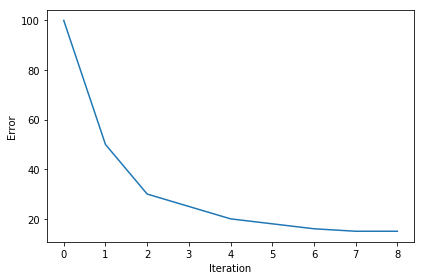

In [19]:
import matplotlib.pyplot as plt

# Plot the training error for every iteration
# in every epoch

# TODO Implement
all_errors = [iteration for epoch in nn.cost for iteration in epoch]

plt.plot(all_errors)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.tight_layout()
plt.show()

---
**Points:** $0.0$ of $1.0$
**Comments:** None

---

In [18]:
# Plot the training error in every epoch
# TODO Implement
epoch_errors = [epoch[-1] for epoch in nn.cost]

plt.plot(epoch_errors)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.tight_layout()
plt.show()

AttributeError: 'Fully_connected_Neural_Network' object has no attribute 'cost'

---
**Points:** $0.0$ of $1.0$
**Comments:** None

---

In [ ]:
from sklearn.metrics import accuracy_score
# Compute Training Accuracy
# TODO Implement

acc = accuracy_score(Y_trainval,nn.inference(X_trainval))
print('Training accuracy: %.2f%%' % (acc * 100))

# Compute Test Accuracy
# TODO Implement

acc = accuracy_score(Y_test,nn.inference(X_test))
print('Test accuracy: %.2f%%' % (acc * 100))

---
**Points:** $0.0$ of $0.5$
**Comments:** None

---

## Submission instructions
You should provide a single Jupyter notebook (.ipynb file) as the solution. Put the names and student ids of your team members below. **Make sure to submit only 1 solution to only 1 tutor.**

- Lukas Schmitt, 2538271
- Gayeon Ross, 2568941
- Benedikt Jesuiter, 2570845

## Points: 0.0 of 30.0 points